# Usando o AutoEncoder Esparso para minimizar o sobreajuste nas tarefas de classificação com o emprego do AutoML

Nathalia Alvim e Aderval Luna


Agradecimento: Programa de Pós Graduação de Engenharia Química da Universidade do Estado do Rio de Janeiro (UERJ), 2025.



## Objetivos

- AutoML

- Evitar o overfitting

- AutoEncoder Esparso

## Metodologia

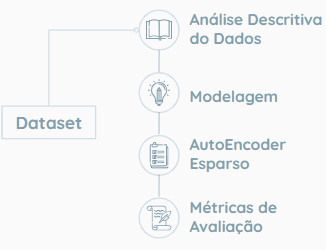

## Banco de dados

- Chemical Composition of Ceramic Samples

- 17 variáveis

- 88 amostras

- 2 Clases (Body e Glaze)


Link do dataset - https://archive.ics.uci.edu/dataset/583/chemical+composition+of+ceramic+samples

## Pacotes

In [ ]:
# Instalar o lazypredict
!pip install lazypredict
!pip install tensorflow
!pip install --upgrade jupyter ipywidgets

In [ ]:
# Inserir os bancos do python:
#Manipulação de dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import shapiro, anderson
#Modelagem
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, cross_validate
from lazypredict.Supervised import LazyClassifier
# Escolhendo o modelo (1) e as metricas de avaliação
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
#Escolhendo o modelo (2)
from sklearn.ensemble import RandomForestClassifier
#Modelo autoencoder
from sklearn.neighbors import KNeighborsClassifier
#Autoencoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
import os
import random

## Inserir o dataset

O dataset deve ser carregado no servidor do colab.

In [ ]:
# Inserir o banco de dados
dataceramica = "/workspaces/Machine-Learning/Chemical Composion of Ceramic.csv"
dataset = pd.read_csv(dataceramica)

In [ ]:
# Visualizar as primeiras linhas do banco de dados
print(dataset.head())

## Análise Descritiva dos Dados

In [ ]:
# Transformar %m/m para ppm, são as colunas 3 até 10
dataset.iloc[:, 2:10] = dataset.iloc[:, 2:10] * 10_000

# Exibir o resultado
print("Dataset atualizado:")
print(dataset.head())

In [ ]:
# Transforma todos os valores negativos em positivos
dataset = dataset.applymap(lambda x: abs(x) if isinstance(x, (int, float)) else x)

# Verificando se ainda há valores negativos
negativos_restantes = (dataset.select_dtypes(include=[np.number]) < 0).sum().sum()
print(f"Total de valores negativos restantes: {negativos_restantes}")

As classes já estão balanceadas, são 44 amostras de body e 44 de glaze

In [ ]:
# Estatística descritiva
# Selecionar apenas colunas numéricas
cn = dataset.select_dtypes(include=['number'])

# Verificar presença de valores NaN
na_counts = cn.isna().sum()
na_columns = na_counts[na_counts > 0]

if not na_columns.empty:
    print("\n⚠️ Valores ausentes encontrados nas seguintes colunas:")
    print(na_columns)

    print("\n📍 Localização dos NaNs:")
    for col in na_columns.index:
        print(f"- {col}: índices com NaN → {cn[cn[col].isna()].index.tolist()}")
else:
    print("\n✅ Nenhum valor NaN encontrado nas colunas numéricas.")

# Calcular estatísticas
media = cn.mean()
mediana = cn.median()
moda = cn.mode().iloc[0]  # Pega a primeira moda encontrada para cada coluna

# Exibir resultados
print("\n📊 Média de cada coluna:")
print(media)

print("\n📊 Mediana de cada coluna:")
print(mediana)

print("\n📊 Moda de cada coluna:")
print(moda)

### Boxplot

In [ ]:
# Gerar boxplot para visualizar a distribuição e possíveis outliers
plt.figure(figsize=(10, 6))
cn.boxplot()
plt.title("Boxplot do Dataset")
plt.xlabel("Colunas")
plt.ylabel("Valores")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Gerar boxplots em pares para economizar espaço
colunas = cn.columns
num_colunas = len(colunas)

# Iterar sobre as colunas em pares
for i in range(0, num_colunas, 2):
    # Configurar o subplot para 2 gráficos lado a lado
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Primeiro boxplot
    axes[0].boxplot(cn[colunas[i]].dropna(), vert=True, patch_artist=True)
    axes[0].set_title(f"Boxplot - {colunas[i]}")
    axes[0].set_xlabel(colunas[i])
    axes[0].set_ylabel("Valores")

    # Segundo boxplot (se existir)
    if i + 1 < num_colunas:
        axes[1].boxplot(cn[colunas[i + 1]].dropna(), vert=True, patch_artist=True)
        axes[1].set_title(f"Boxplot - {colunas[i + 1]}")
        axes[1].set_xlabel(colunas[i + 1])
        axes[1].set_ylabel("Valores")
    else:
        # Remover o segundo subplot se não houver uma segunda coluna
        fig.delaxes(axes[1])

    # Ajustar o layout
    plt.tight_layout()
    plt.show()

In [ ]:
# Inicializar dicionários para guardar os resultados
outliers_info = []

# Iterar sobre as colunas numéricas
for col in cn.select_dtypes(include='number').columns:
    # Remover valores nulos
    data = cn[col].dropna()

    # Calcular Q1, Q3 e IQR
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Identificar os outliers
    outliers = data[(data < limite_inferior) | (data > limite_superior)]
    total = len(data)
    qtd_outliers = len(outliers)
    perc_outliers = (qtd_outliers / total) * 100

    # Armazenar os resultados
    outliers_info.append({
        "Variável": col,
        "Outliers": qtd_outliers,
        "Porcentagem de outliers (%)": round(perc_outliers, 2)
    })

# Criar DataFrame com os resultados
df_outliers = pd.DataFrame(outliers_info)

# Exibir a tabela
print(df_outliers)

### Histograma

In [ ]:
# Iterar sobre as colunas em pares
for i in range(0, num_colunas, 2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Primeiro histograma
    axes[0].hist(cn[colunas[i]].dropna(), bins=30, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histograma - {colunas[i]}")
    axes[0].set_xlabel(colunas[i])
    axes[0].set_ylabel("Frequência")

    # Segundo histograma (se houver)
    if i + 1 < num_colunas:
        axes[1].hist(cn[colunas[i + 1]].dropna(), bins=30, color='salmon', edgecolor='black')
        axes[1].set_title(f"Histograma - {colunas[i + 1]}")
        axes[1].set_xlabel(colunas[i + 1])
        axes[1].set_ylabel("Frequência")
    else:
        fig.delaxes(axes[1])  # Remove o eixo extra se não houver segunda coluna

    plt.tight_layout()
    plt.show()

### Shapiro-Wilk e Anderson-Darling

In [ ]:
# Armazenar os resultados
resultados = []

# Iterar sobre colunas numéricas
for col in cn.select_dtypes(include='number').columns:
    data = cn[col].dropna()

    # Teste de Shapiro-Wilk (n < 5000 recomendado)
    stat_shapiro, p_shapiro = shapiro(data)
    normal_shapiro = 'Sim' if p_shapiro > 0.05 else 'Não'

    # Teste de Anderson-Darling
    result_anderson = anderson(data, dist='norm')
    stat_anderson = result_anderson.statistic
    crit_values = result_anderson.critical_values
    significance = result_anderson.significance_level

    # Verifica se a estatística está abaixo do valor crítico a 5%
    lim_critico_5 = crit_values[significance.tolist().index(5.0)]
    normal_anderson = 'Sim' if stat_anderson < lim_critico_5 else 'Não'

    # Armazenar resultados
    resultados.append({
        'Variável': col,
        'Shapiro-Wilk (p-valor)': round(p_shapiro, 4),
        'Normal (Shapiro)?': normal_shapiro,
        'Anderson-Darling (estatística)': round(stat_anderson, 4),
        'Crítico 5%': round(lim_critico_5, 4),
        'Normal (Anderson)?': normal_anderson
    })

# Criar DataFrame com os resultados
df_normalidade = pd.DataFrame(resultados)

# Exibir os resultados
print(df_normalidade)

### Mapa de Correlação

**Spearman**:

- Dados não lineares e não se preocupa com a distribuição normal dos dados e quando contém outliers


In [ ]:
# Mapa de correlação de Sperman
# Calcular a matriz de correlação (coeficiente de Spearman)
correlacao_spearman = cn.corr(method='spearman')

# Gerar o mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlacao_spearman, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, square=True)
plt.title("Mapa de Correlação (Spearman)")
plt.show()

In [ ]:
# Função para selecionar pares de variáveis com correlação maior que 0.7 (em valor absoluto)
def selecionar_variaveis_correlacao(correlacao, metodo):
    correlacao_forte = []
    for i in range(len(correlacao.columns)):
        for j in range(i + 1, len(correlacao.columns)):
            if abs(correlacao.iloc[i, j]) > 0.7:  # Critério de correlação > 0.7
                correlacao_forte.append((correlacao.index[i], correlacao.columns[j], correlacao.iloc[i, j]))
    return pd.DataFrame(correlacao_forte, columns=["Variável 1", "Variável 2", f"Correlação ({metodo})"])

# Selecionar pares de variáveis com correlação forte
correlacao_forte_spearman = selecionar_variaveis_correlacao(correlacao_spearman, "Spearman")

# Exibir os resultados
print("\nPares de variáveis com correlação forte (Spearman):")
print(correlacao_forte_spearman)

Transformar variavél categórica alvo em variável binária

**Body** - 0

**Glaze** - 1

In [ ]:
# Substituir "Body" por 0 e "Glaze" por 1 apenas na coluna 'Part'
df = dataset.copy()
df['Part'] = df['Part'].replace({'Body': 0, 'Glaze': 1})

# Verificar o resultado
print(df.head())


In [ ]:
#Removendo a coluna Ceramic Name
df.drop(columns=['Ceramic Name'], inplace=True)
print(df.head())

## Separação das variáveis teste e treino

80% treino

20% teste

variável alvo - body ou glaze (part)

In [ ]:
# Normalização
# Selecionar apenas as colunas numéricas para normalização
colunas_numericas = df.select_dtypes(include=['number'])

# Aplicar a normalização Min-Max
scaler = MinMaxScaler()
dados_normalizados = scaler.fit_transform(colunas_numericas)

# Criar um novo DataFrame com os dados normalizados
df_normalizado = pd.DataFrame(dados_normalizados, columns=colunas_numericas.columns)

# Exibir os dados normalizados
print(df_normalizado.head())

# Adicionar colunas categóricas de volta, se necessário
#colunas_categoricas = df.select_dtypes(exclude=['number'])
#df_final = pd.concat([df_normalizado, colunas_categoricas.reset_index(drop=True)], axis=1)

In [ ]:
# Separar as variáveis independentes (X) e dependente (y)
X = df_normalizado.drop(columns=['Part'])  # Variáveis preditoras
y = df_normalizado['Part']                 # Variável alvo

# Dividir o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42  # 20% para teste
)

# Exibir os tamanhos dos conjuntos
print(f"Tamanho do conjunto de treino: {X_train.shape[0]} linhas")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]} linhas")

Pela quantidade de amostras e variáveis não haverá redução de dimensionalidade e nem exclusão de variáveis com alta correlação e nem exclusão de outliers.

## Modelagem

In [ ]:
# Inicializar o LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Ajustar e comparar modelos
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Exibir os resultados
print(models)


In [ ]:
# Exibir os top 5 modelos
print(models.head(5))

### AdaBoostClassifier

In [ ]:
# Inicializar e treinar o AdaBoostClassifier
model = AdaBoostClassifier(n_estimators=25, random_state=42)  # Ajuste n_estimators conforme necessário
model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

In [ ]:
# Relatório de classificação detalhado
print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# Matriz de confusão
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

### Permutando o conjunto de teste

Body - 1
Glaze - 0

In [ ]:
# Criar uma cópia do dataset
df_permutado = df.copy()

# Inverter os valores apenas na coluna 'Part': 0 vira 1 e 1 vira 0
df_permutado['Part'] = df_permutado['Part'].replace({0: 1, 1: 0})

# Verificar o resultado
print(df_permutado.head())

In [ ]:
# Normalização
# Selecionar apenas as colunas numéricas para normalização
colunas_numericas_per = df_permutado.select_dtypes(include=['number'])

# Aplicar a normalização Min-Max
scaler = MinMaxScaler()
dados_normalizados_per = scaler.fit_transform(colunas_numericas_per)

# Criar um novo DataFrame com os dados normalizados
df_normalizado_per = pd.DataFrame(dados_normalizados_per, columns=colunas_numericas_per.columns)

# Exibir os dados normalizados
print(df_normalizado_per.head())

# Adicionar colunas categóricas de volta, se necessário
#colunas_categoricas_per = df_permutado.select_dtypes(exclude=['number'])
#df_final_per = pd.concat([df_normalizado_per, colunas_categoricas_per.reset_index(drop=True)], axis=1)

In [ ]:
# Separar as variáveis independentes (X) e dependente (y)
y_per = df_normalizado_per['Part']                 # Variável alvo

# Dividir o dataset em treino e teste
X_train, X_test, y_train_per, y_test_per = train_test_split(
    X, y_per, test_size=0.2, random_state=42  # 20% para teste
)

# Exibir os tamanhos dos conjuntos
print(f"Tamanho do conjunto de treino: {X_train.shape[0]} linhas")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]} linhas")

In [ ]:
# Inicializar e treinar o AdaBoostClassifier
model = AdaBoostClassifier(n_estimators=25, random_state=42)  # Ajuste n_estimators conforme necessário
model.fit(X_train, y_train_per)

# Fazer previsões no conjunto de teste
y_pred_per = model.predict(X_test)

In [ ]:
# Relatório de classificação detalhado
print("\nClassification Report:\n", classification_report(y_test_per, y_pred_per))

In [ ]:
# Matriz de confusão
print("\nConfusion Matrix:\n", confusion_matrix(y_test_per, y_pred_per))

###Random Forest

Mais robusto e menos sujeito a overfitting

In [ ]:
# Ajuste do modelo com hiperparâmetros ajustados
model_2 = RandomForestClassifier(
    n_estimators=15,  # Reduzir o número de árvores
    max_depth=10,     # Limitar a profundidade das árvores
    min_samples_split=10,  # Aumentar o número mínimo de amostras para dividir um nó
    min_samples_leaf=4,    # Aumentar o número mínimo de amostras por folha
    max_features="sqrt",   # Limitar o número de características consideradas
    random_state=42
)

model_2.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred_2 = model_2.predict(X_test)

In [ ]:
# Relatório de classificação detalhado
print("\nClassification Report:\n", classification_report(y_test, y_pred_2))

In [ ]:
# Matriz de confusão
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_2))

### Permutação


In [ ]:
# Criar o modelo RandomForestClassifier
model_perm = RandomForestClassifier(
    n_estimators=25,
    random_state=42
)

# Treinar o modelo no conjunto permutado
model_perm.fit(X_train, y_train_per)

# Fazer previsões no conjunto de teste permutado
y_pred_per_2 = model_perm.predict(X_test)

In [ ]:
# Relatório de classificação detalhado
print("\nClassification Report:\n", classification_report(y_test_per, y_pred_per_2))

In [ ]:
# Matriz de confusão
print("\nConfusion Matrix:\n", confusion_matrix(y_test_per, y_pred_per_2))

 O modelo está com um sobreajuste



##Autoencoder

In [ ]:
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # força operações determinísticas no TF

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# Definir a arquitetura do autoencoder esparso
input_dim = X_train.shape[1]  # Número de features
encoding_dim = 10  # Dimensão da camada latente
l1_penalty = 1e-5  # Penalidade L1 para esparsidade (ajustável)

# Camada de entrada
input_layer = Input(shape=(input_dim,))
# Camada de codificação com regularização L1
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(l1_penalty))(input_layer)
# Camada de decodificação
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Definir e compilar o autoencoder
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Treinamento do autoencoder
autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test),
                verbose=1)

# Encoder separado para extrair representações latentes
encoder = Model(input_layer, encoded)
X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)

# Treinar modelo RandomForest com os dados latentes
model_2 = RandomForestClassifier(n_estimators=15, max_depth=10,
                                 min_samples_split=10, min_samples_leaf=4,
                                 random_state=42)
model_2.fit(X_train_latent, y_train)

# Previsões e acurácia
y_pred_2 = model_2.predict(X_test_latent)
accuracy_2 = accuracy_score(y_test, y_pred_2)
print(f"Acurácia com autoencoder esparso: {accuracy_2:.4f}")



In [ ]:
#Novo conjunto de dados
df_latent = pd.DataFrame(X_train_latent)
print("\nExemplo do novo conjunto de dados latentes (treino):")
print(df_latent.head())

print(f"Número de amostras no conjunto latente de treino: {X_train_latent.shape[0]}")
print(f"Número de variáveis (features) latentes: {X_train_latent.shape[1]}")

## Modelagem após autoencoder

In [ ]:
# Criar o LazyClassifier
clf = LazyClassifier(verbose=1, ignore_warnings=True, custom_metric=accuracy_score, random_state=42)

# Treinar e testar modelos nos dados latentes
models, predictions = clf.fit(X_train_latent, X_test_latent, y_train, y_test)

# Exibir os resultados
print("\nResultados do LazyClassifier com representações latentes:")
print(models)

In [ ]:
# Mostrar os 5 primeiros
print(models.head(5))

### KNN

In [ ]:
# Inicializar e treinar o modelo KNN
model_1 = KNeighborsClassifier(n_neighbors=5)  # você pode ajustar esse valor depois com otimização
model_1.fit(X_train_latent, y_train)

# Fazer previsões no conjunto de teste
y_pred_autoencoder = model_1.predict(X_test_latent)

# Relatório de classificação
print("\nClassification Report:\n", classification_report(y_test, y_pred_autoencoder))

**UTILIZANDO APENAS O KneighborsClassifier**

## Matriz de confusão, curva ROC

In [ ]:
# 1. Matriz de Confusão LabelPropagation
conf_matrix = confusion_matrix(y_test, y_pred_autoencoder)
print("Matriz de Confusão:")
print(conf_matrix)

In [ ]:
# Plot da matriz de confusão
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Body', 'Glaze'],
            yticklabels=['Body', 'Glaze'])

plt.title('Matriz de Confusão - KNN')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

In [ ]:
# 3. Curva ROC e AUC
# Probabilidades preditas para a classe positiva (assumindo que y_test é binário)
y_prob = model_1.predict_proba(X_test_latent)[:, 1]

# Calcular fpr, tpr e thresholds para a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plotar a Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Exibir a AUC
print(f"AUC: {roc_auc:.4f}")

## Permutação

In [ ]:
# Treinar o modelo com os dados permutados
model_1.fit(X_train_latent, y_train_per)

# Fazer previsões no conjunto de teste
y_pred_permuted = model_1.predict(X_test_latent)

# Relatório de classificação detalhado
print("\nClassification Report:\n", classification_report(y_test, y_pred_permuted))

In [ ]:
# 1. Matriz de Confusão KNN Permutado
conf_matrix_per = confusion_matrix(y_test, y_pred_permuted)
print("Matriz de Confusão:")
print(conf_matrix_per)

In [ ]:
# Plot da matriz de confusão
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_per, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Body', 'Glaze'],
            yticklabels=['Body', 'Glaze'])

plt.title('Matriz de Confusão - KNN')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

In [ ]:
# Inverter as probabilidades preditas
y_prob_invertido = 1 - y_prob

# Recalcular a curva ROC
fpr_inv, tpr_inv, _ = roc_curve(y_test, y_prob_invertido)
roc_auc_inv = auc(fpr_inv, tpr_inv)

print(f"AUC invertido: {roc_auc_inv:.4f}")